In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [17]:
ROBOT_INFO_SIZE = 3
CLUSTER_INFO_SIZE = 4

In [51]:
df = pd.read_csv('robot1with_hard_detection_trial_1.csv', header=None)
N_CLUSTERS = int(len(df.loc[0] - ROBOT_INFO_SIZE) / CLUSTER_INFO_SIZE)
column_names = ['robot_x', 'robot_y', 'robot_angle']
for i in range(N_CLUSTERS):
    column_names.extend([f'cluster{i}_x', f'cluster{i}_y', f'cluster{i}_angle', f'cluster{i}_w'])
df.columns = column_names

In [52]:
df.head()

,robot_x,robot_y,robot_angle,cluster0_x,cluster0_y,cluster0_angle,cluster0_w,cluster1_x,cluster1_y,cluster1_angle,...,cluster5_angle,cluster5_w,cluster6_x,cluster6_y,cluster6_angle,cluster6_w,cluster7_x,cluster7_y,cluster7_angle,cluster7_w
0,9.37286,29.0520,0.046507,93.5308,11.7267,2.58973,0.073017,110.950,38.5397,3.11075,...,4.21033,0.061501,73.1507,57.5449,3.20885,0.141442,29.4691,80.7306,3.17374,0.169215
1,9.68583,29.0601,-0.006441,92.7031,11.4096,2.25234,0.107055,113.607,39.8132,2.90231,...,3.27294,0.072767,71.8157,59.1499,3.13072,0.145572,27.1678,76.7314,3.01955,0.124939
2,10.02700,29.0438,-0.090467,94.5245,12.0474,2.42945,0.085191,112.365,39.6701,3.07723,...,4.10309,0.084727,71.2890,58.4382,3.25472,0.170705,22.3761,72.6373,3.09582,0.126807
3,10.43110,28.9872,-0.188968,99.7373,12.4920,2.50888,0.078391,111.608,41.9554,2.97150,...,3.70303,0.084912,70.2216,60.2860,2.98671,0.186158,23.0162,70.9025,2.91262,0.122014
4,10.89090,28.8714,-0.308522,99.7561,13.5430,2.29835,0.081620,113.487,43.0934,2.90953,...,3.58458,0.086409,67.8643,57.4282,2.63567,0.195149,22.2460,68.3639,2.86414,0.130816


In [69]:
def compute_estimated_position_x(row):
    estimated_x = 0
    sum_weights = 0
    for i in range(N_CLUSTERS):
        estimated_x += row[f'cluster{i}_x'] * row[f'cluster{i}_w']
        sum_weights += row[f'cluster{i}_w']
        
    return estimated_x / sum_weights

def compute_estimated_position_y(row):
    estimated_y = 0
    sum_weights = 0
    for i in range(N_CLUSTERS):
        estimated_y += row[f'cluster{i}_y'] * row[f'cluster{i}_w']
        sum_weights += row[f'cluster{i}_w']
        
    return estimated_y / sum_weights
    
def compute_estimation_eror(row):
    diff_x_square = (row['robot_x'] - row['estimated_x']) ** 2
    diff_y_square = (row['robot_y'] - row['estimated_y']) ** 2
    return np.sqrt(diff_x_square + diff_y_square)

df['estimated_x'] = df.apply(compute_estimated_position_x, axis=1)
df['estimated_y'] = df.apply(compute_estimated_position_y, axis=1)
df['error'] = df.apply(compute_estimation_eror, axis=1)

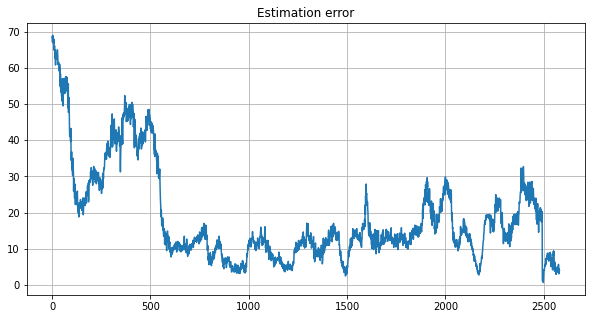

In [77]:
plt.figure(figsize=(10, 5))
plt.title('Estimation error')
plt.plot(df.error)
plt.grid()
plt.show()

Done!